In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from model import BayesianBehaviorAgent
from env.tmaze import TMazeEnv

PyBulletClientMode = 'GUI' 
env = TMazeEnv(mode=PyBulletClientMode, obs='vision', seed=42)
task_name = "tmaze"

device = "cuda" if torch.cuda.is_available() else "cpu"

c:\python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def draw_tmaze(plot_exit_line=False):

    zoom_coef = 2

    xv = []
    yv = []
    cv = []

    # top-left
    xv.append([-5, -4, -4, -5, -5])
    yv.append([-1, -1, 3, 3, -1])
    cv.append([0.8000, 0.38000, 0.1000])

    # top-right
    xv.append([5, 4, 4, 5, 5])
    yv.append([-1, -1, 3, 3, -1])
    cv.append([0.1000, 0.3800, 0.8000])

    # top
    xv.append([2.5, -2.5, -2.5, 2.5, 2.5])
    yv.append([2, 2, 3, 3, 2])
    cv.append([0.5200, 0.5200, 0.5200])

    # middle-left
    xv.append([-1.5, -4, -4, -1.5, -1.5])
    yv.append([-1, -1, 0, 0, -1])
    cv.append([0.8000, 0.5000, 0.5000])

    # middle-right
    xv.append([1.5, 4, 4, 1.5, 1.5])
    yv.append([-1, -1, 0, 0, -1])
    cv.append([0.5000, 0.5000, 0.8000])

    # bottom-left
    xv.append([-1.5, -1.5, -0.5, -0.5, -0.5])
    yv.append([-4, 0, 0, -4, -4])
    cv.append([0.5200, 0.5200, 0.5200])

    # bottom-right
    xv.append([1.5, 1.5, 0.5, 0.5, 0.5])
    yv.append([-4, 0, 0, -4, -4])
    cv.append([0.5200, 0.5200, 0.5200])

    # bottom
    xv.append([-1.5, -1.5, 1.5, 1.5, 1.5])
    yv.append([-4, -5, -5, -4, -4])
    cv.append([0.7200, 0.2400, 0.7200])

    if plot_exit_line:
        # exit line
        xv.append([-4, -2.5, -2.5, -4, -4])
        yv.append([2, 2, 2.05, 2.05, 2])
        cv.append([0.2200, 0.8200, 0.2200])

        # exit line
        xv.append([4, 2.5, 2.5, 4, 4])
        yv.append([2, 2, 2.05, 2.05, 2])
        cv.append([0.2200, 0.8200, 0.2200])

    for i in range(len(xv)):
        plt.fill([xi * zoom_coef for xi in xv[i]], 
                 [yi * zoom_coef for yi in yv[i]], 
                 color=cv[i], 
                 edgecolor='none')

    plt.xlim([-10.5, 10.5])
    plt.ylim([-10.5, 6.5])
    plt.axis('off')
    plt.box(False)


## Load agent model (please change the model path in your case)
### The model can be downloaded at the Release page of this repo
https://github.com/oist-cnru/The-Bayesian-Behavior-Framework/releases/tag/demo

In [3]:
agent = torch.load("pretrained_agent_example.model", map_location=device)
agent.device = device

## Define the goal observation (here use the observation at start position as example)

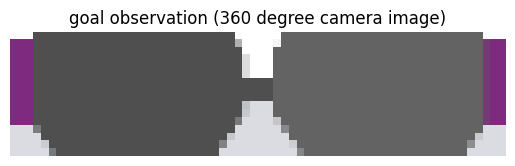

In [4]:
goal_obs = env.reset()

plt.imshow(goal_obs.swapaxes(0,2).swapaxes(0,1))
plt.axis('off')
plt.title("goal observation (360 degree camera image)")
plt.show()

## Run goal-directed planning

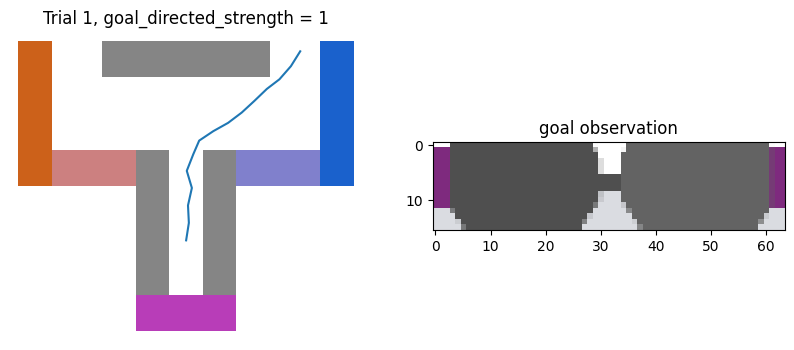

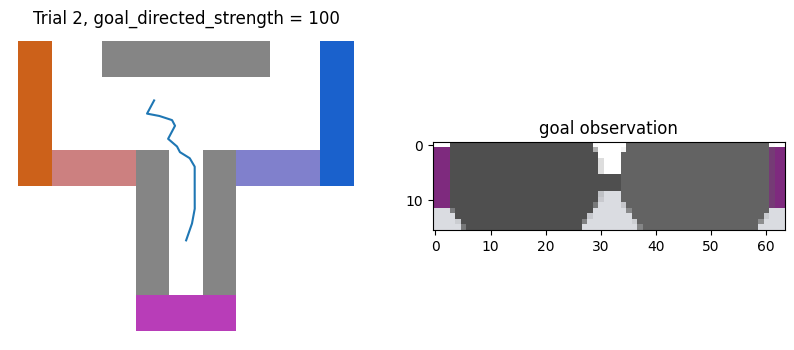

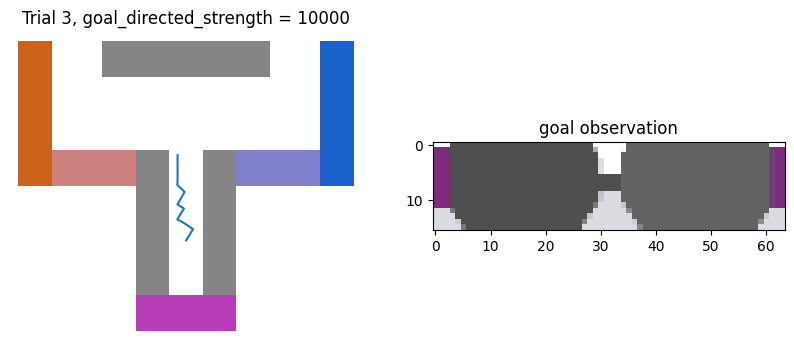

In [5]:
num_trials_planning = 3  

for episode in range(num_trials_planning):

    goal_directed_strength = 100 ** episode  # habitual behavior's constraint is smaller if this value is larger 
    # increasing goal_directed_strength in later trials

    goal_function = lambda x: goal_directed_strength * torch.sum(
        ((torch.sigmoid(x) - torch.from_numpy(goal_obs).to(device=device)).abs().sum(-3) < 0.25).to(torch.float32), dim=[-1, -2])
    # note this can be changed: basic rule is that the goal function should be smaller if the agent is closer to the goal

    sp = env.reset()
    agent.init_states()
    infos = np.zeros([15 + 1, 2], dtype=np.float32)  # position information
    infos[0] = env.info['ob']

    for t in range(15):

        sp, r, done, info, action = agent.step_with_env(env, sp, goal_obs, behavior='goal-directed', action_return='mean', goal_function=goal_function)     

        # if t == 1:
        #     goal_obs = sp

        infos[t + 1] = info['ob']

    # Visualize trajecotry
    plt.figure(figsize=[10, 4])
    plt.subplot(1,2,1)
    draw_tmaze()
    plt.plot(infos[:t + 1, 0], infos[:t + 1, 1])
    plt.title("Trial {}, goal_directed_strength = {}".format(episode + 1, goal_directed_strength))
    plt.subplot(1,2,2)
    plt.imshow(goal_obs.swapaxes(0,2).swapaxes(0,1))
    plt.title("goal observation")
    plt.show()

